In [20]:
import pandas as pd
from scipy import stats
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import Lasso
import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import plotly.graph_objs as go
import plotly.io as pio
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn.tree import export_graphviz


f = '/Users/shenchingfeng/Documents/1112/機器學習/Homework 2/all.csv'

df = pd.read_csv(f)
df.drop(['Unnamed: 0'], axis = 1, inplace = True) ## Red wine == 1 ; White wine == 0

result = pd.DataFrame(columns = ["model", "accuracy"])

select_col = df.drop('wine', axis = 1).columns
for i in select_col:
    df[i], lambda_value = stats.yeojohnson(df[i])

# Cross Validation

### 10-Fold CV

In [21]:
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

### Grid Search CV

In [22]:
model = RandomForestClassifier()

X = df.drop(['wine', 'density'], axis = 1)
y = df.wine

params = {
    'n_estimators': list(range(100, 501, 50)),
    'max_depth': [1, 3, 5, 7, 9],
    'max_features': ['sqrt', 'log2'],  
    'criterion': ['gini', 'entropy'] 
}

grid_search = GridSearchCV(model, param_grid = params, cv = kf, n_jobs = -1)
grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

result = result.append({'model': 'Random Forest', 'accuracy': round(grid_search.best_score_, 4)}, ignore_index = True)

KeyboardInterrupt: 

# Feature Selection

## Stepwise Selection

In [6]:
for i in range(7):
    sfs = SFS(
    cv = kf, 
    estimator = RandomForestClassifier(criterion = 'entropy',  max_depth = 4, max_features = 'sqrt', n_estimators = 250, n_jobs = -1),
    forward = True,
    floating = True,
    k_features = i+1, 
    scoring ='f1',
    n_jobs = -1
)
    sfs.fit(X, y)

    print(sfs.k_feature_names_)
    print(sfs.k_score_)
    print("=======================================")

('chlorides',)
0.8419820680363234
('chlorides', 'total sulfur dioxide')
0.9475946054551363
('chlorides', 'total sulfur dioxide', 'sulphates')
0.9631482761039696
('volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates')
0.9700148254837316
('fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates')
0.9741081818031752
('fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates')
0.975369703043581
('fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol')
0.9778785631786591


In [7]:
metric_dict = sfs.get_metric_dict()
k_features = list(metric_dict.keys())
avg_scores = np.array([metric_dict[k]['avg_score'] for k in k_features])
std_devs = np.array([metric_dict[k]['std_dev'] for k in k_features])

fig = go.Figure()
fig.add_trace(
    go.Scatter(
    x = k_features, y = avg_scores, 
    mode = 'lines+markers', name = 'Average Score'
    )
)

fig.update_layout(
    title = {
        'text': 'Stepwise Selection',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 'x': 0.5
    }, 
    xaxis_title = {
        'text': 'Number of Features',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    yaxis_title = {
        'text': 'Performence (F1)',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    width = 1200, height = 800
)

fig.show()

## Lasso

In [ ]:
X = df.drop(['wine', 'density'], axis = 1)
y = df.wine

from sklearn.linear_model import Lasso
lasso = Lasso()
params = {
    'alpha': [10**i for i in range(-10, 11)],
    'selection': ['cyclic', 'random']
}
gridlasso = GridSearchCV(lasso, param_grid = params, cv = kf, n_jobs = -1)
gridlasso.fit(X, y)

print("Best alpha:", gridlasso.best_params_)
print("Best scores:", gridlasso.best_score_)

coefficients = gridlasso.best_estimator_.coef_
importance = np.abs(coefficients)
print(np.array(X.columns)[importance > 1])
print(importance)

Best alpha: {'alpha': 1e-08, 'selection': 'random'}
Best scores: 0.8312860264728428
['fixed acidity' 'volatile acidity' 'chlorides' 'pH' 'sulphates' 'alcohol']
[1.94012268e+01 3.13999017e+00 1.15308809e-01 1.18270863e-02
 2.08427751e+01 1.89202679e-02 7.04227274e-03 0.00000000e+00
 4.42252089e+01 2.38130996e+00 1.87684773e+01 2.36408251e-02]


In [ ]:
best_lasso = gridlasso.best_estimator_

alphas = np.array(gridlasso.cv_results_['param_alpha'].data, dtype = 'float')
coefs = gridlasso.cv_results_['mean_test_score']

fig = go.Figure()

fig.add_trace(
    go.Scatter(
    x = np.log10(alphas), y = coefs, 
    mode = 'lines+markers'
    )
)

fig.update_layout(
    title = {
        'text': 'Lasso coefficients as a function of Log alpha',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 
        'x': 0.5
    }, 
    width = 1200, height = 800,
    xaxis_title = {
        'text': 'Log(alpha)',
        'font': {
            'size': 24, 'family': 'Gulliver'
        }
    }, 
    yaxis_title = {
        'text': 'Coefficient',
        'font': {'size': 24, 'family': 'Gulliver'}
    }, 
)

fig.show()

## Feature Group

In [8]:
Stepwise = ['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates']
Lasso =  ['fixed acidity', 'volatile acidity', 'chlorides', 'pH', 'sulphates', 'alcohol']

feature = []

for i in df.drop('wine', axis = 1).columns:
    for i in Stepwise:
        if i not in feature:
            feature.append(i)
        else:
            continue
    for i in Lasso:
        if i not in feature:
            feature.append(i)
        else:
            continue
print(feature)

['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'pH', 'alcohol']


# Model

In [31]:
X = df[feature]
y = df.wine

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 42)

scl = StandardScaler()
x_train = scl.fit_transform(x_train)
x_test = scl.transform(x_test)

rfc = RandomForestClassifier(criterion = 'entropy', max_depth = 8, max_features = 'sqrt', n_estimators = 200)
model = rfc.fit(x_train, y_train)
y_pred = model.predict(x_test)

## Model Performance

[7/7] features ████████████████████ Time elapsed: 0 seconds

Text(0.5, 1.0, 'Feature Importance of Random Forest')

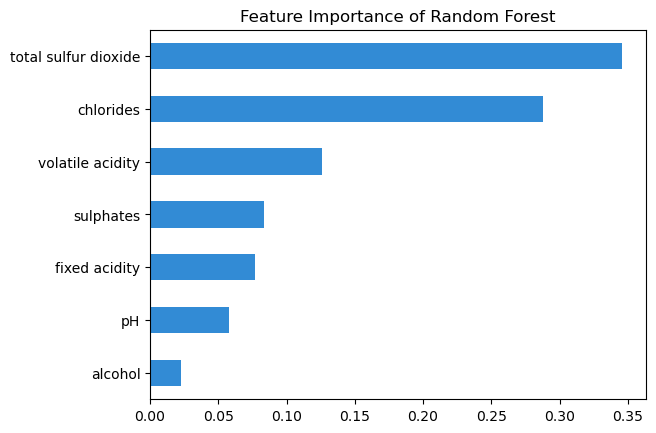

In [10]:
interpreter = Interpretation(
    x_test, feature_names = X.columns
)

pyint_model = InMemoryModel(
    rfc.predict_proba,
    examples = x_train
)

plots= interpreter.feature_importance.plot_feature_importance(pyint_model, ascending = False, progressbar = True)
plt.title('Feature Importance of Random Forest')

## Decision Tree

In [29]:
rfc = RandomForestClassifier(criterion = 'entropy', max_depth = 4, max_features = 'sqrt', n_estimators = 250)
rfc.fit(x_train, y_train)

tree = rfc.estimators_[0]
dot_data = export_graphviz(
    tree, 
    out_file = None, 
    feature_names = df[feature].columns, 
    class_names = ["White ", "Red"], 
    filled = True, 
    rounded = True, 
    special_characters = True, 
    node_ids = False,
    impurity = False,
)

graph = graphviz.Source(dot_data)
graph.render("Rfc decision tree")

'Rfc decision tree.pdf'

## Decision Region

In [11]:
feature_name = 'total sulfur dioxide'
feature_num = X.columns.get_loc(feature_name)
print(feature_num)
feature_name = 'chlorides'
feature_num = X.columns.get_loc(feature_name)
print(feature_num)

3
2


### With mlxtend.plotting plot_decision_regions()

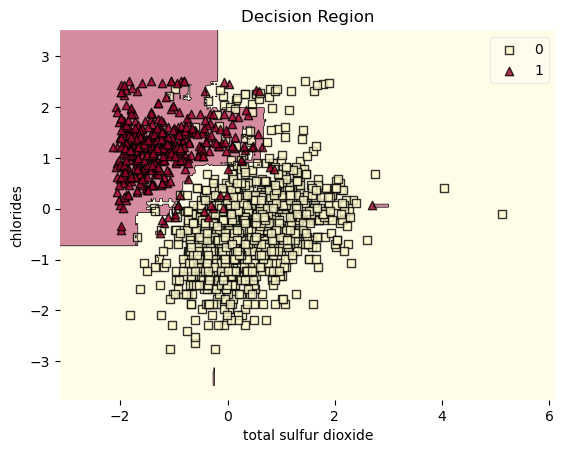

In [12]:
plot_decision_regions(
    x_test[:, [3, 2]], 
    y_test.values, 
    clf = rfc.fit(x_train[:, [3, 2]], y_train.values),
    colors = '#fffacd,#a00028'
)

plt.title('Decision Region')
plt.xlabel('total sulfur dioxide')
plt.ylabel('chlorides')
plt.show()

### With Scatter plot of Plotly

In [ ]:
trace = go.Scatter(
    x = x_test[:, 1],
    y = x_test[:, 6],
    mode = 'markers',
    marker = dict(
        color = y_pred,
        symbol = y_pred,
        size = 8,
        opacity = 0.9,
        colorscale = [[0, '#fffacd'], [1, '#a00028']],
        line = dict(color = '#444444', width = 0.5)
    )
)

layout = go.Layout(
    title = {
        'text': 'Decision Region',
        'font': {
            'size': 40, 'family': 'Gulliver'
        }, 'x': 0.5
    },
    xaxis = dict(
        title = {
            'text': 'volatile acidity', 
            'font': {
                'size': 24, 'family': 'Gulliver'
            }
        }
    ),
    yaxis = dict(
        title = {
            'text': 'total sulfur dioxide', 
            'font': {
                'size': 24, 'family': 'Gulliver'
            }
        }
    ),
    margin = dict(l = 50, r = 50, t = 80, b = 50),
    hovermode = 'closest', 
    width = 800, height = 800,
    showlegend = False,
    template = 'ggplot2'
)

fig = go.Figure(
    data = [trace], 
    layout = layout
)

pio.show(fig)

## Confusion Matrix

In [14]:
acu = metrics.accuracy_score(y_test, y_pred)
pre_class, r_class, f_class, sup = metrics.precision_recall_fscore_support(y_test, y_pred, average = 'weighted')

print("Acurracy: ", round(acu * 100, 4), '%')
print('Precision:', round(pre_class * 100, 4), '%')
print('Recall:', round(r_class * 100, 4), '%')
print('f1:', round(f_class * 100, 4), '%')

cm = metrics.confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
cm_norm = pd.DataFrame(cm_norm)
cm_norm

Acurracy:  99.5077 %
Precision: 99.509 %
Recall: 99.5077 %
f1: 99.5066 %


,0,1
0,0.999160,0.000840
1,0.016129,0.983871


## Receiver Operating Characteristic Curve

In [32]:
fpr, tpr, _ = roc_curve(
    y_test, 
    model.predict_proba(x_test)[:, 1]
)

roc_auc = auc(fpr, tpr)

trace1 = go.Scatter(
    x = fpr, y = tpr, 
    mode = 'lines', 
    line = dict(width = 2),
)

trace2 = go.Scatter(
        x = [0, 1], y = [0, 1],
        mode = 'lines',
        line = dict(color = 'navy', width = 2, dash = 'dash'),
        showlegend = False
)

layout = go.Layout(
        title = {
            'text': 'ROC Curves (AUC = {:0.2f})'.format(roc_auc),
            'font': {
                'size': 40, 'family': 'Gulliver'
            }, 
            'x': 0.5, 'y': 0.95
        },
        xaxis = dict(
            title = {
                'text': 'False Positive Rate',
                'font': {
                    'size': 24, 'family': 'Gulliver'
                }
            }
        ),
        yaxis = dict(
            title = {
                'text': 'True Positive Rate',
                'font': {
                    'size': 24, 'family': 'Gulliver'
                }
            }
        ),
        width = 1200, height = 800,
        showlegend = False
)

fig = go.Figure(
    data = [trace1, trace2], 
    layout = layout
)

fig.show()

# Model Compexity

In [27]:
n_estimators_range = range(1, 501)

train_errors = []
test_errors = []

for i in n_estimators_range:
    rfc = RandomForestClassifier(criterion = 'entropy', max_depth = 4, max_features = 'sqrt', n_estimators = i, n_jobs = -1)
    rfc.fit(x_train, y_train)
    train_pred = rfc.predict(x_train)
    test_pred = rfc.predict(x_test)
    train_errors.append(1 - accuracy_score(y_train, train_pred))
    test_errors.append(1 - accuracy_score(y_test, test_pred))


fig = go.Figure()

fig.add_trace(
    go.Scatter(
    x = [ i for i in range(1, 501) ], y = train_errors,
    mode = 'lines',
    name = 'Train Error'
    )
)

fig.add_trace(
    go.Scatter(
    x = [ i for i in range(1, 501) ], y = test_errors,
    mode = 'lines',
    name = 'Test Error'
    )
)

fig.update_layout(
    title = {
        'text': 'Model Complexity for Random Forest',
        'font': {
            'size': 32, 'family': 'Gulliver'
        },
        'x': 0.5
    }, 
    width = 800, height = 600,
    xaxis_title = {
        'text': 'n estimators',
        'font': {
            'size': 24, 'family': 'Gulliver'
        },
    },
    yaxis_title = {
        'text': 'Classification Error',
        'font': {
            'size': 24, 'family': 'Gulliver'
        },
    }
)
fig.show()